# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [ ]:
!ls


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%matplotlib inline

#Time series analysis tools.
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pylab import rcParams
plt.style.use('fivethirtyeight')

from fbprophet import Prophet as proph

In [4]:
# Helpful functions 

def melt_data(df):
    mdf = pd.melt(df, id_vars=['RegionName', 'City', 'Metro', 'State', 'CountyName', 'SizeRank'], 
                 value_vars = df.loc[:, '1996-04':'2018-04'], value_name = 'Value', var_name = 'Date')
    mdf_cleaned = mdf.dropna(subset=['Value', 'Metro'])
    return mdf_cleaned

def subset_zipcode(zipcode, df):
    df_12 = df.copy()
    df_12 = df_12[df_12['RegionName'] == zipcode]
    df_12.drop(columns=['RegionName'], inplace=True)
    df_12.rename(columns={'Date': 'ds', 'Value': 'y'}, inplace=True)
    return df_12

def prophet_m(zipcode, df):   
    Model = proph(interval_width=0.95) 
    date_value_df = subset_zipcode(zipcode, df)
    Model.fit(date_value_df)
    future_dates = Model.make_future_dataframe(periods=12, freq='MS')
    forecast = Model.predict(future_dates).tail(1)
    
    
    ds = forecast['ds'].iloc[0]
    y_hat = forecast['yhat'].values[0]
    y_hat_lower = forecast['yhat_lower'].values[0]
    y_hat_upper = forecast['yhat_upper'].values[0]
    current_price = date_value_df['y'].iloc[-1]

    return (ds, y_hat, y_hat_lower, y_hat_upper, current_price)

def prophet_graph(df):
    df = df.rename(columns={'Date': 'ds',
                        'Value': 'y'})
    Model = proph(interval_width=0.95)
    Model.fit(df)
    future_dates = Model.make_future_dataframe(periods=12, freq='MS')
    forecast = Model.predict(future_dates)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    Model.plot(forecast, uncertainty=True)
    return plt.show()

In [35]:
df_zillow = pd.read_csv('zillow_data.csv')

# Step 2: Data Preprocessing

In [ ]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [10]:
df = melt_data(df_zillow)
df.head()

,RegionName,City,Metro,State,CountyName,SizeRank,Date,Value
0,60657,Chicago,Chicago,IL,Cook,1,1996-04,334200.0
1,75070,McKinney,Dallas-Fort Worth,TX,Collin,2,1996-04,235700.0
2,77494,Katy,Houston,TX,Harris,3,1996-04,210400.0
3,60614,Chicago,Chicago,IL,Cook,4,1996-04,498100.0
4,79936,El Paso,El Paso,TX,El Paso,5,1996-04,77300.0


In [11]:
print(df_zillow.SizeRank.describe(),'\n')
#Calculate the 20% cutoff value.
one_per_df = df.SizeRank.quantile(q=0.01)
size_rank_df = df.loc[df['SizeRank']< one_per_df]

count    14723.000000
mean      7362.000000
std       4250.308342
min          1.000000
25%       3681.500000
50%       7362.000000
75%      11042.500000
max      14723.000000
Name: SizeRank, dtype: float64 



In [ ]:
zipcodes = size_rank_df['RegionName'].unique()
predictions = []
for zipcode in zipcodes:
    ds, y_hat, y_hat_lower, y_hat_upper, current_price = prophet_m(zipcode, size_rank_df) #(current $, predicted $, upper, lower)
    predictions.append({'zip': zipcode,
                        'ds': ds,
                        'y_hat': y_hat,
                        'y_hat_lower': y_hat_lower,
                        'y_hat_upper': y_hat_upper,
                        'current_price': current_price})

In [ ]:
df_pred = pd.DataFrame(predictions)

In [ ]:
df_pred['diff'] = df_pred['y_hat'] - df_pred['current_price'] 

In [ ]:
df_pred.sort_values(by='diff', ascending=False).head()

In [26]:
# importing prediction.csv, no need to run upper codes 

prediction_df = pd.read_csv('home_value_prediction/prediction.csv')

In [37]:
df_zillow.loc[df_zillow['RegionName'] == 98052]            

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
67,99534,98052,Redmond,WA,Seattle,King,68,219700.0,219900.0,220200.0,...,843400,852500,861700,873200,886000,900500,915200,924700,929300,930600


In [27]:
prediction_df.sort_values(by='diff', ascending=False).head()

,Unnamed: 0,current_price,ds,y_hat,y_hat_lower,y_hat_upper,zip,diff
56,56,1854300.0,2019-04-01,2.113064e+06,2.064652e+06,2.160554e+06,7030,258763.992588
74,74,1419100.0,2019-04-01,1.627992e+06,1.571867e+06,1.685322e+06,90034,208891.855820
30,30,1966900.0,2019-04-01,2.168947e+06,2.075317e+06,2.270130e+06,90046,202047.359744
131,131,1489900.0,2019-04-01,1.655067e+06,1.587448e+06,1.727028e+06,90066,165166.552627
66,66,930600.0,2019-04-01,1.076904e+06,1.044679e+06,1.107075e+06,98052,146304.295695


In [28]:
# Taking top 5 zipcode from df 
ts_7030 = df.loc[df['RegionName'] == 7030]
ts_90034 = df.loc[df['RegionName'] == 90034]
ts_90046 = df.loc[df['RegionName'] == 90046]
ts_90066 = df.loc[df['RegionName'] == 90066]
ts_98052 = df.loc[df['RegionName'] == 98052]

In [29]:
# choosing columns Date and Value to do prophet anlaysis
ts_7030 = ts_7030[['Date', 'Value']]  
ts_90034 = ts_90034[['Date', 'Value']]
ts_90046 = ts_90046[['Date', 'Value']]
ts_90066 = ts_90066[['Date', 'Value']]
ts_98052 = ts_98052[['Date', 'Value']]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


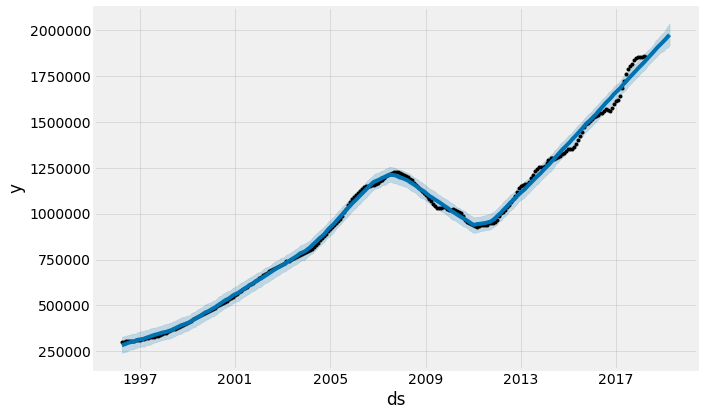

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


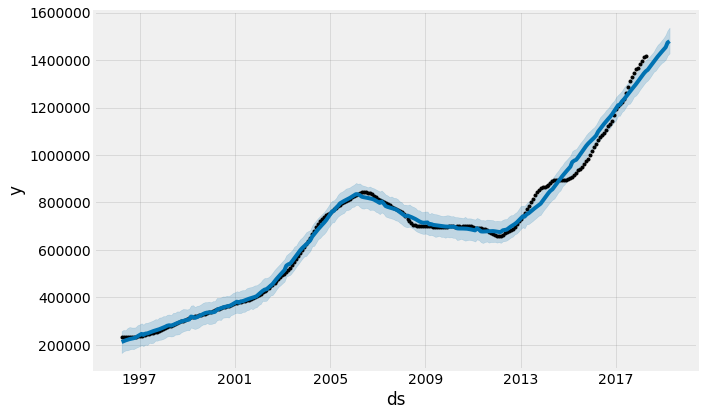

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


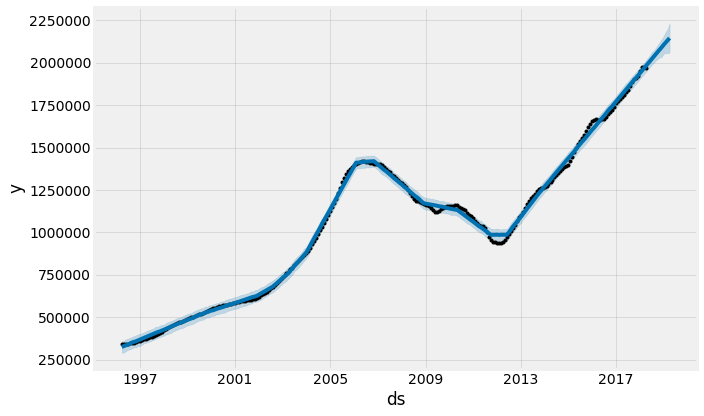

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


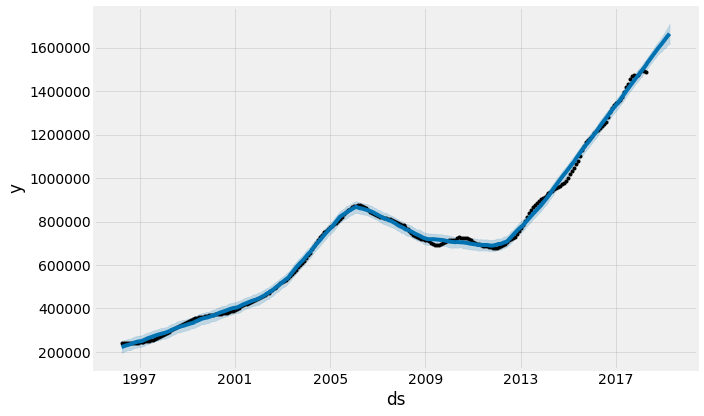

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


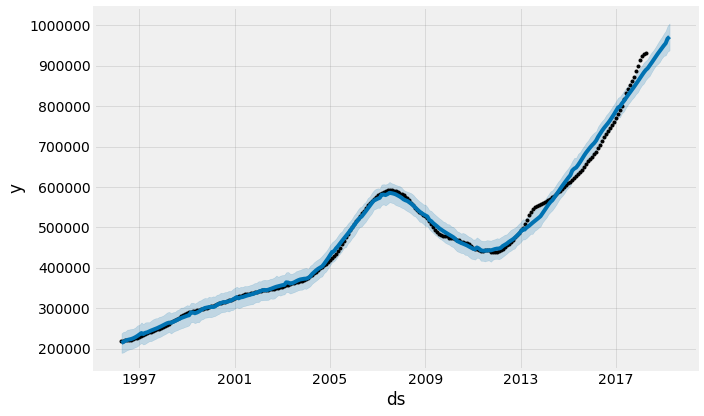

In [30]:
prophet_graph(ts_7030)
prophet_graph(ts_90034)
prophet_graph(ts_90046)
prophet_graph(ts_90066)
prophet_graph(ts_98052)


In [31]:
best_zip5 = best_zip.loc[(best_zip['RegionName'] == 7030) | (best_zip['RegionName'] == 90034) 
                             | (best_zip['RegionName'] == 90046) | (best_zip['RegionName'] == 90066)
                             | (best_zip['RegionName'] == 98052)]
best_zip5.head()

NameError: name 'best_zip' is not defined

In [32]:
dfs_t = best_zip5[['RegionName','Date','Value']]
dfs_t.head()

NameError: name 'best_zip5' is not defined

In [ ]:
dfs_t.Date = pd.to_datetime(dfs_t.Date)
dfs_t = dfs_t.set_index('Date')
dfs_t.index = pd.DatetimeIndex(dfs_t.index)

In [ ]:
dfs_ts = []
for zc in dfs_t.RegionName.unique():
    #Create separate dataframes for each zipcode with a monthly frequency.
    df = dfs_t[dfs_t['RegionName']==zc]
    dfs_ts.append(df)
print('\nZipcode 90046 time series:')
dfs_ts[0].head()

In [ ]:
dfs_ts[1].head()

In [ ]:
dfs_ts[1].columns

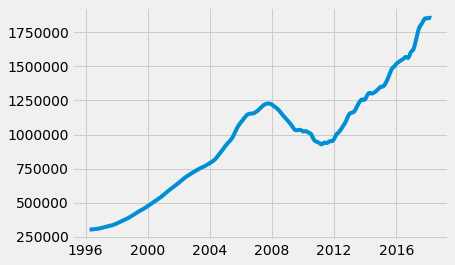

In [178]:
plt.plot(dfs_ts[1].Value);

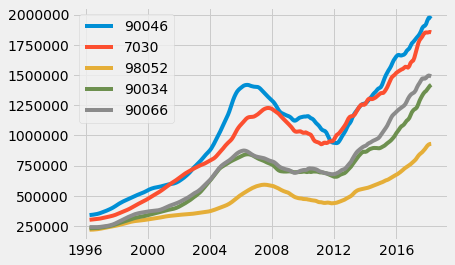

In [180]:
for i in range(5):
    plt.plot(dfs_ts[i].Value, label=dfs_ts[i].RegionName[0])
    plt.legend()

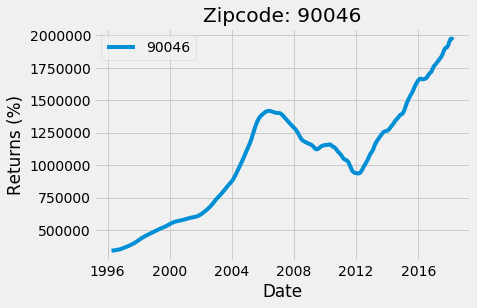

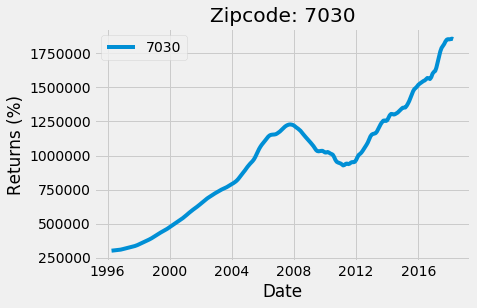

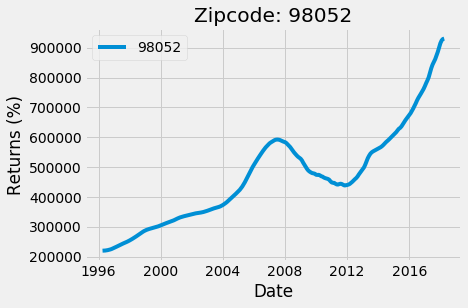

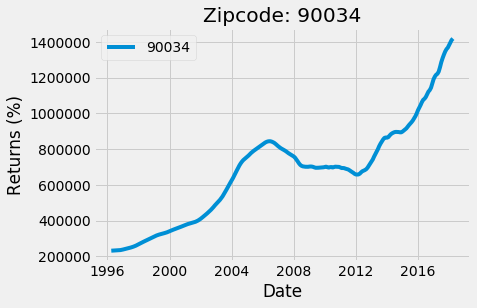

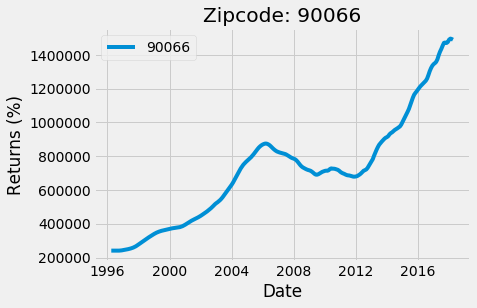

In [182]:
for i in range(len(dfs_ts)):
    plt.plot(dfs_ts[i].Value, label=dfs_ts[i].RegionName[0])
    plt.title(f'Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.xlabel('Date')
    plt.ylabel('Returns (%)')
    plt.legend(loc='best')
    plt.show()

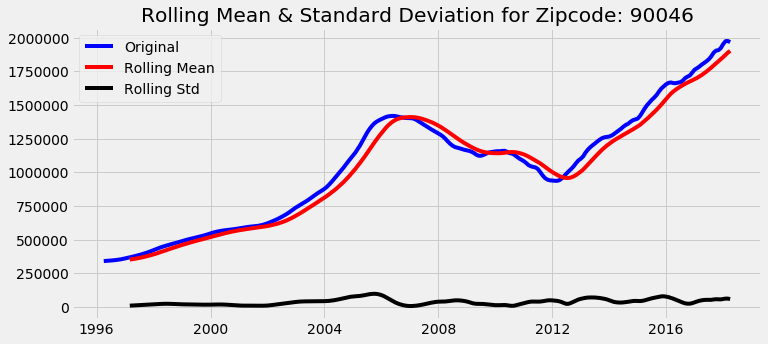

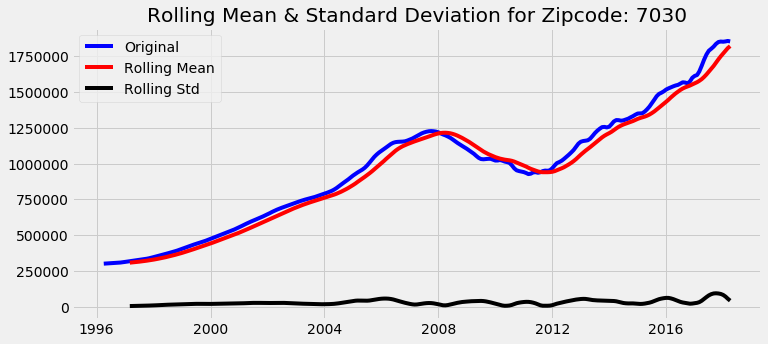

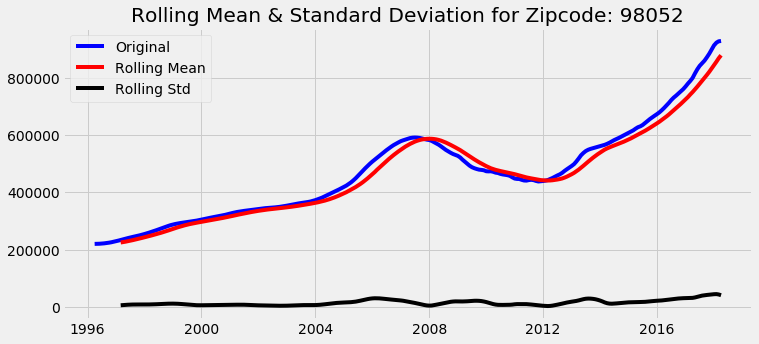

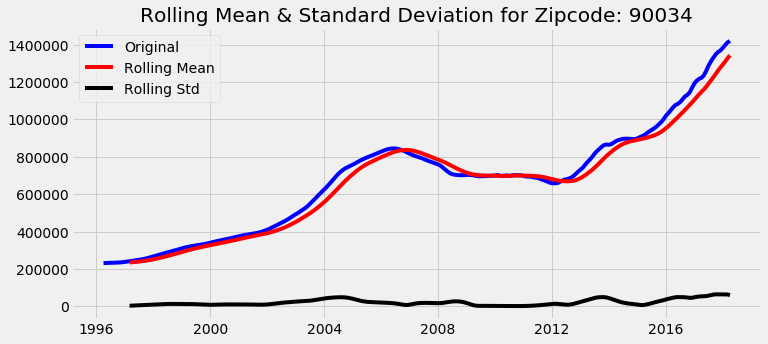

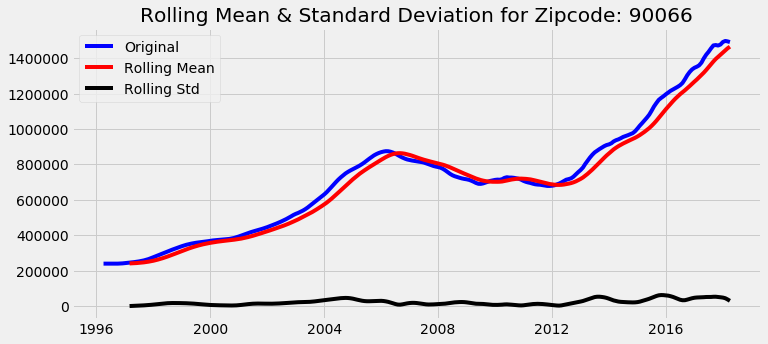

In [183]:
for i in range(len(dfs_ts)):
    rolmean = dfs_ts[i].Value.rolling(window = 12, center = False).mean()
    rolstd = dfs_ts[i].Value.rolling(window = 12, center = False).std()
    fig = plt.figure(figsize=(11,5))
    orig = plt.plot(dfs_ts[i].Value, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.show()

In [184]:
for i in range(5):
    results = adfuller(dfs_ts[i].Value.dropna())
    print(f'ADFuller test p-value for zipcode: {dfs_ts[i].RegionName[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 90046
p-value: 0.7621567166816606
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 7030
p-value: 0.8913263672522288
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 98052
p-value: 0.9064442718592205
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 90034
p-value: 0.9497148224721286
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 90066
p-value: 0.8634462873263347
Fail to reject the null hypothesis. Data is not stationary.



In [185]:
#Calculate monthly returns in new column 'ret' for each zipcode.
for zc in range(len(dfs_ts)):
    dfs_ts[zc]['ret']=np.nan*len(dfs_ts[zc])
    for i in range(len(dfs_ts[zc])-1):
        dfs_ts[zc]['ret'][i+1]= (dfs_ts[zc].Value.iloc[i+1] / dfs_ts[zc].Value.iloc[i]) - 1

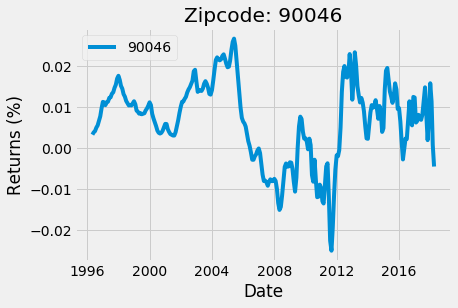

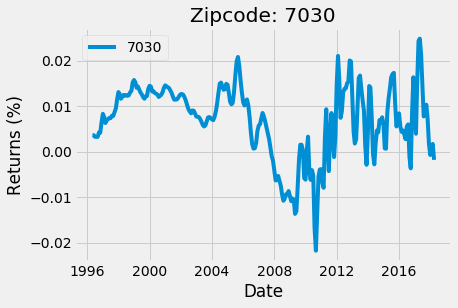

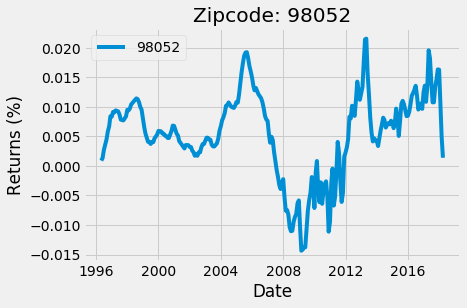

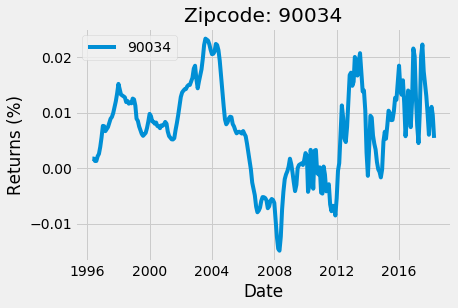

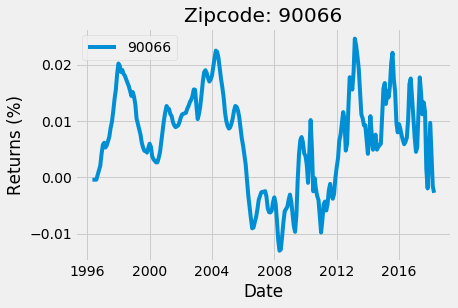

In [188]:
for i in range(len(dfs_ts)):
    plt.plot(dfs_ts[i].ret, label=dfs_ts[i].RegionName[0])
#     dfs_ts[i].ret.plot(figsize=(11,5), color = 'b')
    plt.title(f'Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.xlabel('Date')
    plt.ylabel('Returns (%)')
    plt.legend(loc='best')
    plt.show()

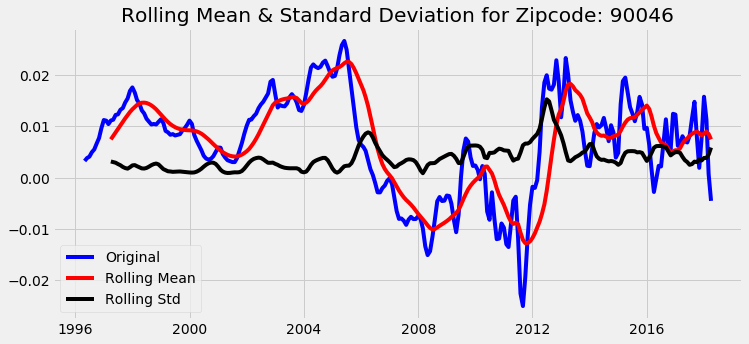

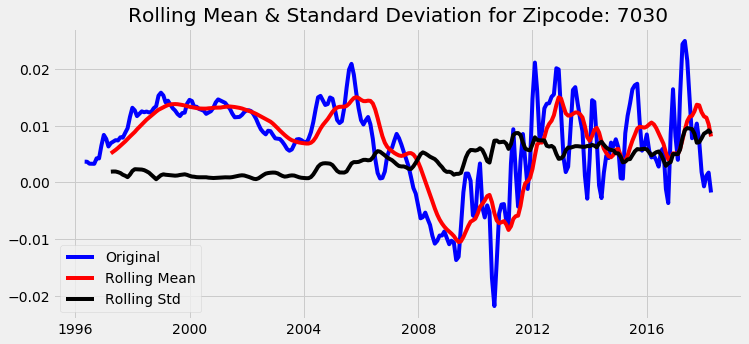

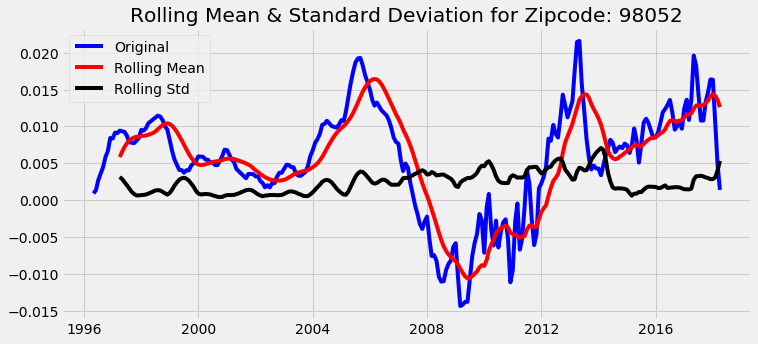

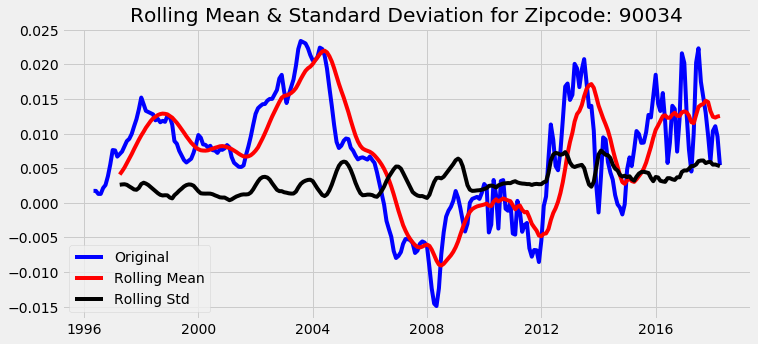

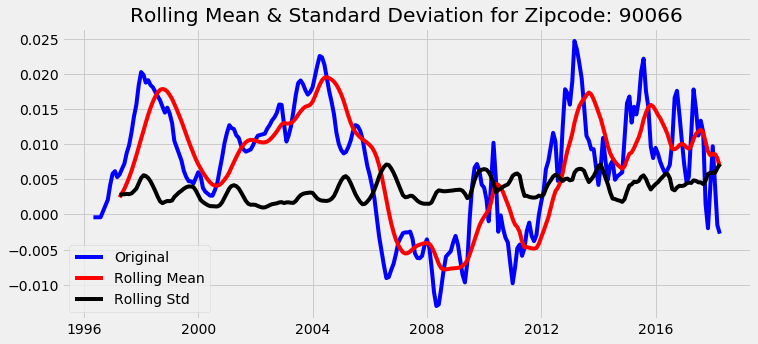

In [189]:
for i in range(len(dfs_ts)):
    rolmean = dfs_ts[i].ret.rolling(window = 12, center = False).mean()
    rolstd = dfs_ts[i].ret.rolling(window = 12, center = False).std()
    fig = plt.figure(figsize=(11,5))
    orig = plt.plot(dfs_ts[i].ret, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.show()

In [190]:
for i in range(5):
    results = adfuller(dfs_ts[i].ret.diff().dropna())
    print(f'ADFuller test p-value for zipcode: {dfs_ts[i].RegionName[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 90046
p-value: 9.995588187546272e-07
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 7030
p-value: 7.326952672530468e-05
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 98052
p-value: 0.021903638416093225
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 90034
p-value: 0.0008678380595283124
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 90066
p-value: 4.458858135962074e-06
Reject the null hypothesis. Data is stationary.



# Step 3: EDA and Visualization

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

# Step 4: Reshape from Wide to Long Format

In [ ]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

# Step 5: ARIMA Modeling

# Step 6: Interpreting Results